## AutoEncoder 와 Supervised Learning 합쳐서 해보기

* 이유 1 : AutoEncoder는 Unsupervised learning 방법으로, 내부적으로 좋은 Rerpresentation을 만들어 줄 수 있을 거라고 생각함. 
    * + Shared Network를 통해 Weight를 줄여서, 압축된 정보를 얻게 하는 것이 목적
* 이유 2 : SL만으로 하면 레이블에 대한 과적합된 네트워크를 얻을 것 같음.그래서 다른 네트워크와 결합을 통해 이러한 부분을 해소하는 것을 기대함.

* 이 버전에서의 생각
    * 각각 1번씩 돌리게 함.
        * AutoEncoder 
        * SL
    * AutoEncoder 학습 후 Pretrained Network로 한 것은 실제로 그냥 쓰는 것보다 못하다는 사실을 확인함.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd , sys
import matplotlib.pyplot as plt
import scikitplot as skplt
from IPython.display import clear_output
from sklearn.metrics import auc , roc_auc_score
from sklearn.model_selection import train_test_split
sys.path.append("/home/advice/Python/SR/Custom/")
from RAdam import RAdamOptimizer
import seaborn as sns
import re , os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scikitplot as skplot
from ColumnMatch import MatchVariable

In [2]:
from tensorflow.contrib.layers import *
def get_weight_variable(shape, name=None,
                        type='xavier_uniform', regularize=True, **kwargs):
    initialise_from_constant = False
    if type == 'xavier_uniform':
        initial = xavier_initializer(uniform=True, dtype=tf.float32)
    elif type == 'xavier_normal':
        initial = xavier_initializer(uniform=False, dtype=tf.float32)
    elif type == 'he_normal':
        initial = variance_scaling_initializer(uniform=False, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'he_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'caffe_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=1.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'simple':
        stddev = kwargs.get('stddev', 0.02)
        initial = tf.truncated_normal(shape, stddev=stddev, dtype=tf.float32)
        initialise_from_constant = True
    elif type == 'bilinear':
        weights = _bilinear_upsample_weights(shape)
        initial = tf.constant(weights, shape=shape, dtype=tf.float32)
        initialise_from_constant = True
    else:
        raise ValueError('Unknown initialisation requested: %s' % type)

    if name is None:  # This keeps to option open to use unnamed Variables
        weight = tf.Variable(initial)
    else:
        if initialise_from_constant:
            weight = tf.get_variable(name, initializer=initial)
        else:
            weight = tf.get_variable(name, shape=shape, initializer=initial)
    if regularize:
        tf.add_to_collection('weight_variables', weight)
    return weight 

In [3]:
import os
os.path.abspath("./../../../Data/")

'/home/advice/Python/SR/Data'

In [4]:
data = pd.read_csv("./../../../Data/kdd/uci/uci_creditcard-train-0.2-0.0.csv")
in_var = ["LIMIT_BAL", "SEX", "EDUCATION", "MARRIAGE", "AGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
          "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
          "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
target_var = ['default payment next month']
fac_var = [ 'SEX','EDUCATION','MARRIAGE',]
num_var = [i for i in in_var if not i in fac_var]
#in_var = num_var + fac_var
data[fac_var] = data[fac_var].astype("category")

In [5]:
cat_col = data.select_dtypes("category").columns.tolist()
onehot_data = pd.get_dummies(data , columns= cat_col)

In [6]:
select_var = in_var + target_var + ["sep_idx"]
data = data[select_var]

In [7]:
train = data[data.sep_idx ==1 ]
valid = data[data.sep_idx ==0 ]
## 
train = data
_ = train.pop("sep_idx")
_ = valid.pop("sep_idx")

In [8]:
Train_X = pd.get_dummies(train , columns= cat_col)
Train_y = Train_X.pop(target_var[0])

In [9]:
num_var = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [10]:
one_hot_var = Train_X.columns.tolist()
#in_var = data.columns.tolist()

In [11]:
MV = MatchVariable()
in_var = MV.match_onehot_invar(one_hot_var , in_var)

In [12]:
key_onehot_store , onehot_store = MV.OneHotIndex(in_var , num_var , one_hot_var)

In [13]:
weight_info = MV.WeightInfo(onehot_store , Train_X)

In [14]:
#key_onehot_store , onehot_store = OneHotIndex(in_var , num_var , one_hot_var)

In [15]:
def gainloss(M,G,R,weights) :
    diff = G.get_shape().as_list()[1] 
    if diff == 1 :
        sumLoss = mseloss(M,G,R)
    elif diff == 2 :
        sumLoss = multiclassloss(M,G,R,weights)
    else :
        sumLoss = multiclassloss(M,G,R,weights)
    return sumLoss
def mseloss(M,G,R) :
    if M is None :
        sumLoss = tf.reduce_mean(tf.square( R - G ))
    else :
        sumLoss = tf.reduce_sum(M * tf.square( R - G ))
        sumLoss /= tf.clip_by_value(tf.reduce_sum(M),1.0,1e+8)
    return sumLoss 
        
def multiclassloss(M,G,R,weights):
    if M is None :
        M = tf.constant(1.0)
    else :
        M = tf.reshape(tf.slice(M,[0,0],[-1,1]),shape=(1,-1))
    diff = G.get_shape().as_list()[1] 
    labels   = tf.argmax(R, axis = 1 )
    one_hot  = tf.one_hot(labels, depth = diff, dtype = tf.float32)
    class_weights = tf.constant(weights)
    weights = tf.cast(tf.gather(class_weights , labels ) , tf.float32)
    SparseCE = tf.losses.sparse_softmax_cross_entropy(labels, G , weights)
    if M is None :
        sumLoss = tf.reduce_mean(M * SparseCE)
    else :
        sumLoss = tf.reduce_sum(M * SparseCE)
        sumLoss /= tf.clip_by_value(tf.reduce_sum(M),1.0,1e+11)
    return sumLoss

def CatNumEmb(out,  cond , key_cond) :
        rawinputs = []
        onehotinputs  = []
        arginputs = []
        keys = list(key_cond.keys())
        if len(cond) == cond[-1][1] : 
            self.log("All Numeric")
            Input = self.G_final_Act(out)
            Arg   = self.G_final_Act(out)
        else :
            for idx , c in enumerate(cond) :
                StartNode , TerminalNode = c[0] , c[1]
                diff = TerminalNode - StartNode
                split = tf.slice(out , [0 , StartNode ],[-1, diff ] ) # 
                if diff == 1 : 
                    type_ = "numeric"
                    __float__  = split
                    rawinputs.append(__float__)
                    onehotinputs.append(__float__)
                    arginputs.append(__float__)
                else :
                    prob = tf.nn.softmax(split)
                    arg = tf.argmax(prob , axis = 1)
                    onehot = tf.one_hot(arg, depth = diff,
                                        dtype = tf.float32 )
                    arg = tf.expand_dims(tf.cast(arg , tf.float32),axis = 1)
                    rawinputs.append(prob)
                    onehotinputs.append(onehot)
                    arginputs.append(arg)
                    if diff == 2 : type_ = "binary"
                    else : type_ = "multiclass"
                print("Column : {:20} | {:10} | [{}]".format(keys[idx] , type_ , diff))
            Input = tf.concat(rawinputs, axis=1, name='Inputs')
            onehotInput = tf.concat(onehotinputs, axis=1, name='oneHotInputs')
            argInput = tf.concat(arginputs, axis=1, name='Args')
        return Input , onehotInput , argInput

def CatNumEmb_Loss(Gene , Real, Mask  , cond, key_cond , Weight_Info) :
    LOSS = 0
    keys = list(key_cond.keys())
    with tf.variable_scope("Columns/Loss"):
        if len(cond) == cond[-1][1] :
            LOSS = gainloss(Mask,Gene,Real,None)
            for idx , (c, w_info) in enumerate(zip(cond , Weight_Info)) :
                StartNode , TerminalNode = c[0] , c[1]
                diff = TerminalNode - StartNode
                Gsplit = tf.slice(Gene , [0 , StartNode ] ,[-1 , diff] ) 
                Rsplit = tf.slice(Real , [0 , StartNode ] ,[-1 , diff] ) 
                if Mask is None :
                    Msplit = None
                else :
                    Msplit = tf.slice(Mask , [0 , StartNode ] ,[-1 , diff] ) 
                type_   = "mse"
                sumLoss = gainloss(Msplit,Gsplit,Rsplit,None)
                print("StartNode : {:3} | {:10} | [{}]".\
                      format(StartNode , type_ , diff))
        else :
            for idx , (c, w_info) in enumerate(zip(cond , Weight_Info)) :
                StartNode , TerminalNode = c[0] , c[1]
                diff = TerminalNode - StartNode
                Gsplit = tf.slice(Gene , [0 , StartNode ] ,[-1 , diff] ) 
                Rsplit = tf.slice(Real , [0 , StartNode ] ,[-1 , diff] ) 
                if Mask is None :
                    Msplit = None
                else :
                    Msplit = tf.slice(Mask , [0 , StartNode ] ,[-1 , diff] ) 
                sumLoss = gainloss(Msplit,Gsplit,Rsplit,w_info)
                if diff == 1 :   type_ = "mse"
                elif diff == 2 : type_ = "binary"    
                else :           type_ = "multiclass"
                LOSS += sumLoss
                print("StartNode : {:3} | {:10} | [{}]".format(StartNode , type_ , diff))
    return LOSS

In [16]:
test = pd.read_csv("./../../../Data/kdd/uci/uci_creditcard-test-0.2-0.0.csv")
Test_y = test.pop(target_var[0])
Test_X = pd.get_dummies(test , columns= fac_var)[one_hot_var]

In [17]:
Train_y.reset_index(drop=True ,inplace=True)
target_1_list = Train_y[(Train_y == 1) == True].index.tolist()
target_0_list = Train_y[(Train_y == 0) == True].index.tolist()

In [18]:
ck = list(set(target_1_list) & set(target_0_list))
assert ck == [], "중복 발생 : {}".format(ck)

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder ,
    MinMaxScaler , RobustScaler,
    PowerTransformer
)

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from collections import Counter
from copy import deepcopy
class FeatureSelector(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self, feature_names):
        self.feature_names = feature_names
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        return X[self.feature_names]
    
class OutlierTransformer(BaseEstimator, TransformerMixin ):
    #Class constructor method that takes a boolean as its argument
    def __init__(self, new_features = True , multiple_outlier_n = 5):
        self.multiple_outlier_n = multiple_outlier_n
        self.new_features = new_features
    #Return self nothing else to do here    
    def fit( self, X:pd.DataFrame, y = None )-> dict:
        self.Detect_Outlier = {}
        df = deepcopy(X)
        outlier_indices = [] 
        # convert columns to numerical
        self.totalcol = df.columns.tolist()
        print(self.totalcol)
        for name in self.totalcol :
            selectvar = df[name]
            Q1, Q3 = selectvar.quantile([0.25,0.75]).values
            IQR = Q3 - Q1
            minimum , maximum = (Q1 - 1.5 * IQR) , (Q3 + 1.5 * IQR)
            select_idx = (selectvar  < minimum ) | (selectvar > maximum)
            outlier_list_col = selectvar[select_idx].index.tolist()
            outlier_indices.extend(outlier_list_col)
            self.Detect_Outlier[name] = [minimum , maximum]
        outlier_indices = Counter(outlier_indices) 
        multiple_outliers = list(k for k, v in outlier_indices.items() if v > self.multiple_outlier_n)
        print(f"{self.multiple_outlier_n} Column Dudicated Outlier Index : {len(multiple_outliers)}")
        return self
    
    def transform(self, X:pd.DataFrame , y = None ) -> pd.DataFrame :
        df = deepcopy(X)
        for name in self.totalcol :
            selectvar = df[name]
            Q1, Q3 = selectvar.quantile([0.25,0.75]).values
            IQR = Q3 - Q1
            minimum , maximum = self.Detect_Outlier[name]
            select_idx = (selectvar  < minimum ) | (selectvar > maximum)
            selectvar[select_idx] = np.nan
            df[name] = selectvar
        print(df.shape)
        return df    
    def get_feature(self) :
        return self.totalcol

In [21]:
# ("Outlier", OutlierTransformer(multiple_outlier_n=5)),
numeric_pipe = Pipeline([("imputer", SimpleImputer(strategy='mean')),
                         ("scaler2", MinMaxScaler(feature_range=(-1.5,1.5)))])
col_transformer = ColumnTransformer(transformers=[("nums",numeric_pipe , num_var)],n_jobs=None)

In [22]:
col_transformer.fit(Train_X)
Train_X[num_var] = col_transformer.transform(Train_X)
Test_X[num_var] = col_transformer.transform(Test_X)

In [23]:
Train_X_np = Train_X.values
#Valid_X_np = Valid_X.values
Test_X_np = Test_X.values

In [24]:
row , dim = Train_X_np.shape
print(row,dim)
target_n = 2 
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape = [ None , dim])
y = tf.placeholder(tf.float32, shape = [ None , 1])
DropoutRate = tf.placeholder(tf.float32, name ="dropoutRate")
training = tf.placeholder_with_default(False, shape=[], name="training")
global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
batch_size = tf.placeholder(tf.int64)
batch_prob  = tf.placeholder(tf.bool)

30000 33


In [25]:
TOTAL_DIM , h_dim , h_dim2 = dim , 25, 20
Weight_1 =get_weight_variable(shape = [TOTAL_DIM , h_dim], 
                            name=f"W1",type='he_normal', regularize=True)
Weight_2 =get_weight_variable(shape = [h_dim , h_dim], 
                            name=f"W2",type='he_normal', regularize=True)
Weight2 =get_weight_variable(shape = [h_dim , h_dim2], 
                            name=f"W3",type='he_normal', regularize=True)

In [26]:
hdims = [Weight_1 , Weight_2 , Weight2]
def encoder(X , hdims , act, reuse=False ) :
    with tf.variable_scope("Encoder",reuse=reuse):
        for idx , hdim in enumerate(hdims) :
            if idx == len(hdims)-1 :
                Code = tf.matmul(X ,hdim)
            else :
                X = act(tf.matmul(X ,hdim))
    return Code

def decoder(X, hdims, act) :
    with tf.variable_scope("Decoder",reuse=False):
        for idx , hdim in enumerate(hdims[::-1]) :
            if idx == len(hdims)-1 :
                Logit = tf.matmul(X ,hdim, transpose_a=False , transpose_b=True)
            else :
                X = act(tf.matmul(X ,hdim, transpose_a=False , transpose_b=True))
    return Logit

In [27]:
def Layer(X , reuse = False) :
    with tf.variable_scope("Final",reuse=reuse):
        W_1 = tf.get_variable("w_1",shape=[33,20])
        B_1 = tf.get_variable("b_1",shape=[20])
        W_2 = tf.get_variable("w_2",shape=[20,15])
        B_2 = tf.get_variable("b_2",shape=[15])
        W_3 = tf.get_variable("w_3",shape=[15,10])
        B_3 = tf.get_variable("b_3",shape=[10])
        layer1 = tf.matmul(X, W_1) + B_1
        layer1 = tf.layers.batch_normalization(layer1, 
                                               center=True, scale=True, training=batch_prob)
        layer1 = tf.nn.leaky_relu(layer1)
        layer2 = tf.matmul(layer1, W_2) + B_2
        layer2 = tf.layers.batch_normalization(layer2, 
                                               center=True, scale=True, training=batch_prob)
        layer2 = tf.nn.leaky_relu(layer2)
        logit = tf.matmul(layer2, W_3) + B_3
    return tf.nn.selu(logit)

In [28]:
data_tuple = (X,y)
class_dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
class_dataset = class_dataset.shuffle(buffer_size= 30000)
class_dataset = class_dataset.batch(batch_size=batch_size, drop_remainder=True)
iter2 = class_dataset.make_initializable_iterator()
feature_x , label_y = iter2.get_next()

W0404 16:13:38.539316 140499315554048 deprecation.py:323] From <ipython-input-28-2dbf52f6c96f>:5: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [29]:
Code = encoder(feature_x , hdims , tf.nn.selu)
trans_x = decoder(Code , hdims , tf.nn.leaky_relu)
Results = CatNumEmb(trans_x,  onehot_store , key_onehot_store)
output, onehot, _ = Results
loss = CatNumEmb_Loss(output, feature_x, None,
                      onehot_store, key_onehot_store, weight_info)
# Code2 = encoder(feature_x, hdims , tf.nn.selu, True)

Column : LIMIT_BAL            | numeric    | [1]
Column : AGE                  | numeric    | [1]
Column : PAY_0                | numeric    | [1]
Column : PAY_2                | numeric    | [1]
Column : PAY_3                | numeric    | [1]
Column : PAY_4                | numeric    | [1]
Column : PAY_5                | numeric    | [1]
Column : PAY_6                | numeric    | [1]
Column : BILL_AMT1            | numeric    | [1]
Column : BILL_AMT2            | numeric    | [1]
Column : BILL_AMT3            | numeric    | [1]
Column : BILL_AMT4            | numeric    | [1]
Column : BILL_AMT5            | numeric    | [1]
Column : BILL_AMT6            | numeric    | [1]
Column : PAY_AMT1             | numeric    | [1]
Column : PAY_AMT2             | numeric    | [1]
Column : PAY_AMT3             | numeric    | [1]
Column : PAY_AMT4             | numeric    | [1]
Column : PAY_AMT5             | numeric    | [1]
Column : PAY_AMT6             | numeric    | [1]
Column : SEX        

W0404 16:13:38.882863 140499315554048 deprecation.py:323] From /root/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/losses/losses_impl.py:121: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


StartNode :  19 | mse        | [1]
StartNode :  20 | binary     | [2]
StartNode :  22 | multiclass | [7]
StartNode :  29 | multiclass | [4]


In [30]:
Code3 = Layer(feature_x)

W0404 16:13:39.311208 140499315554048 deprecation.py:323] From <ipython-input-27-30aef295a0e5>:11: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
W0404 16:13:39.313009 140499315554048 deprecation.py:323] From /root/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/layers/normalization.py:327: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


In [31]:
ConcateLayer = tf.concat([Code , Code3],axis = 1)

In [32]:
ConcateLayer.get_shape()[1]

Dimension(30)

In [33]:
def FINALLayer(X , reuse = False) :
    with tf.variable_scope("Final_Concat",reuse=reuse):
        W_1 = tf.get_variable("w_1",shape=[X.get_shape()[1],10])
        B_1 = tf.get_variable("b_1",shape=[10])
        W_3 = tf.get_variable("w_3",shape=[10,1])
        B_3 = tf.get_variable("b_3",shape=[1])
#         layer1 = tf.nn.selu(tf.matmul(X, W_1) + B_1)
#         logit = tf.matmul(layer1, W_3) + B_3
        layer1 = tf.matmul(X, W_1) + B_1
        layer1 = tf.layers.batch_normalization(layer1, 
                                               center=True, scale=True, training=batch_prob)
        layer1 = tf.nn.selu(layer1)
        logit = tf.matmul(layer1, W_3) + B_3
    return logit

In [34]:
logit = FINALLayer(ConcateLayer)

In [35]:
prob= tf.nn.sigmoid(logit)
auc_value , update_auc = tf.metrics.auc(label_y , prob , curve="ROC")

W0404 16:13:39.881428 140499315554048 deprecation.py:323] From /root/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/ops/metrics_impl.py:808: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [36]:

# learning_rate = tf.train.exponential_decay(1e-4, global_step, decay_steps=100, decay_rate=0.99, staircase=False )
# solver = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize( ,var_list = hdims  )

In [37]:
class_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "Final") 
totalvars = tf.trainable_variables()

In [38]:
decrease_weight = tf.train.exponential_decay(1.0, global_step, decay_steps=500, decay_rate=0.99, staircase=False)
learning_rate = tf.train.cosine_decay_restarts(2e-5, global_step, first_decay_steps=100, t_mul=1.5,m_mul=0.9, alpha=0.0)
loss2 = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels = label_y ,
                                                                logits=logit,pos_weight=1.5))

In [39]:
L2= []
for v in class_vars :
    L2.append(tf.nn.l2_loss(v))
L2Regularizer= tf.add_n(L2)  * 0.001
loss2 +=L2Regularizer

In [40]:
# decrease_weight*
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    solver2 = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(loss + loss2 ,var_list = totalvars)
    solver_change = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(loss2 ,var_list = class_vars)

In [41]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, TransformedBbox,
                                                   BboxPatch, BboxConnector)
def my_mark_inset(parent_axes, inset_axes, loc1a=1, loc1b=1, loc2a=2, loc2b=2, **kwargs):
    rect = TransformedBbox(inset_axes.viewLim, parent_axes.transData)
    pp = BboxPatch(rect, fill=False, **kwargs)
    parent_axes.add_patch(pp)
    p1 = BboxConnector(inset_axes.bbox, rect, loc1=loc1a, loc2=loc1b, **kwargs)
    inset_axes.add_patch(p1)
    p1.set_clip_on(False)
    p2 = BboxConnector(inset_axes.bbox, rect, loc1=loc2a, loc2=loc2b, **kwargs)
    inset_axes.add_patch(p2)
    p2.set_clip_on(False)
    return pp, p1, p2
def subplotting(ax , store , x , y ,**kwargs) :
    ax.plot(store[x],store[y],**kwargs)
    if kwargs["ylabel"] :
        ax.set_ylabel(kwargs["ylabel"])
    if kwargs["ylim"] :
        ax.set_ylabel(**kwargs["ylim"], fontsize= 15)
    if kwargs["title"] :
        ax.set_title(kwargs["title"])
    ax.legend()
    return ax

In [42]:
## version3
def vis(store:dict, path:str,title:str) :
    clear_output()
    fig = plt.figure(figsize=(10, 12))
    gs = GridSpec(nrows=3, ncols=2)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[0:2, 1])
    ax3 = fig.add_subplot(gs[2, 0])
    ax4 = fig.add_subplot(gs[2, 1])
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.99, 
            top=0.9, wspace=0.2, hspace=0.3)
    ax0.plot(store["epoch"],store["aeloss"],label = "AEloss", color='m')
    ax0.set_ylabel('UnSupervised', fontsize= 15)
    select_ae= np.argmin(store["aeloss"])
    if np.min(store["aeloss"]) > 5 : cut = 0
    else : cut = np.min(store["aeloss"])
    ax0.set_ylim(cut,5)
    ax0.vlines(store["epoch"][select_ae],
               cut ,5, label='Best', color='m')
    a =store["aeloss"][-1]
    ax0.set_title(f'Loss : {a:.4f}')
    ax0.legend()
    ax1.plot(store["epoch"],store["slloss"],label = "SLloss", color='c')
    ax1.set_xlabel('Epoch')
    select_sl= np.argmin(store["slloss"])
    ax1.vlines(store["epoch"][select_sl],
               np.min(store["slloss"]),np.max(store["slloss"]),
               label='Best', color='c')
    a =store["slloss"][-1]
    ax1.set_title(f'Loss : {a:.4f}')
    ax1.set_ylabel('Supervised', fontsize= 15)
    ax1.legend()
    ax2.plot(store["epoch"],store["auc"],label = "Train auc")
    ax2.plot(store["epoch"],store["teauc"],label = "Test auc")
    ax2.set_ylabel('AUC', fontsize= 15)
    ax2.set_xlabel('Epoch')
    select= np.argmax(store["teauc"])
    msg = f"test idx : {store['epoch'][select]}, maximum : {store['teauc'][select]*100:.2f}"
    ax2.set_title(msg)             
#     ax2.set_ylim(0.7,store['auc'][select]+0.1)
    ax2.legend()
    check_n = 4
    if len(store['epoch']) > check_n :
        axins = inset_axes(ax2, "100%", "100%", 
                           bbox_to_anchor=[0.36, .3, .5, .4],
                       bbox_transform=ax2.transAxes, borderpad=0)
        axins.plot(store['epoch'], store['auc'])
        axins.plot(store['epoch'], store['teauc'])
        maximum = np.max(store['auc'][-check_n:] + store['teauc'][-check_n:])
        minumum = np.min(store['auc'][-check_n:] + store['teauc'][-check_n:])
        xlims = (store['epoch'][-check_n],store['epoch'][-1])
        ylims = (minumum, maximum)
        axins.set(xlim=xlims, ylim=ylims)
        my_mark_inset(ax2, axins, loc1a=2, loc1b=3, loc2a=4, loc2b=4, fc="none", ec="0.5") # 
#     msg = f"Epoch : {epoch[-1]}, Loss : {loss[-1]:.3f}, Auc : {aucs[-1]:.3f}"
    sns.boxplot(x="t", y="prob", data=store["train_pd"] , ax = ax3)
    ax3.set_title("train" , fontsize= 15)
    sns.boxplot(x="t", y="prob", data=store["test_pd"] , ax = ax4)
    ax4.set_title("test" , fontsize= 15)
    plt.suptitle(title)
    plt.savefig(path)
    plt.show()

In [43]:
oversample = list(np.arange(len(Train_y))) + 2 * list(np.where(Train_y.values == 1)[0])

In [ ]:
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
Epoch = 100000
maeloss = 10
from matplotlib.gridspec import GridSpec
with tf.Session(config=config) as sess:
    init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init)
    store = {"epoch" : [] , 
             "aeloss" : [], "slloss" : [],
             "auc" : [], "teauc" : []}
    train_pd = pd.DataFrame(columns=["t","prob"])
    test_pd = pd.DataFrame(columns=["t","prob"])
    store["train_pd"] = train_pd
    store["test_pd"] = test_pd
    for i in range(Epoch):    
        batchAeLoss = []
        batchSlLoss = []
        permutation_idx = np.random.permutation(oversample)
        sess.run(iter2.initializer , 
                 feed_dict= {X : Train_X_np[permutation_idx,:],
                             y : Train_y.values.reshape(-1,1)[permutation_idx,:],
                             batch_size : 200,
                            }) # switch to train dataset
        
        while True :
            try :
                ### Supervised Learning & Unsupervised Learning
                
                if maeloss < 2.5 :
                    result  = sess.run([solver_change , loss2 , loss],
                                       feed_dict={global_step:i,batch_prob :True})
                else :
                    result  = sess.run([solver2 , loss2 , loss], 
                                       feed_dict={global_step:i,batch_prob :True})
                batchSlLoss.append(result[1])
                batchAeLoss.append(result[2])
            except tf.errors.OutOfRangeError :
                break
        maeloss = np.mean(batchAeLoss)
        mslloss = np.mean(batchSlLoss)
        print(f"Epoch : {i}, AELoss : {maeloss:.8f} , SLLoss : {mslloss:.8f}" , end = "\r")
        if (i % 100 == 0) :
            sess.run(iter2.initializer , 
                     feed_dict= {X : Train_X_np,
                     y : Train_y.values.reshape(-1,1),
                     batch_size : len(Train_X_np),}) 
            tr_result  = sess.run([prob,label_y], feed_dict ={batch_prob :False})
            sess.run(iter2.initializer , 
                     feed_dict= {X : Test_X_np,
                     y : Test_y.values.reshape(-1,1),
                     batch_size : len(Test_X_np),}) 
            result  = sess.run([prob,label_y], feed_dict ={batch_prob :False})
            
            store["epoch"].append(i)
            store["aeloss"].append(maeloss)
            store["slloss"].append(mslloss)
            store["train_pd"]["prob"] = np.squeeze(tr_result[0])
            store["train_pd"]["t"] = np.squeeze(tr_result[1])
            store["test_pd"]["prob"] = np.squeeze(result[0])
            store["test_pd"]["t"] = np.squeeze(result[1])
            store["auc"].append(roc_auc_score(store["train_pd"]["t"].values,store["train_pd"]["prob"].values))
            store["teauc"].append(roc_auc_score(store["test_pd"]["t"].values,store["test_pd"]["prob"].values))
            vis(store, "./usl_sl_combine_run_train_with_together_oversample.png",
                title = "Train Concatenate SL & UnSL Together(OverSample)")
            clear_output()

```
#         while True :
#             try :
#                 _ , AE_LOSS  = sess.run([solver , loss])
#                 for _ in range(2) :
#                     _, SL_LOSS,_,auc  = sess.run([solver2 , loss2 ,auc_value,update_auc])
#                 batchAeLoss.append(AE_LOSS)
#                 batchSlLoss.append(SL_LOSS)
#                 batchAuc.append(auc)
#             except tf.errors.OutOfRangeError :
#                 break
```

In [76]:
import pickle
with open("resut.pkl","wb") as wb :
    pickle.dump(store , wb)

In [65]:
## version3
def vis(store:dict, path:str) :
    clear_output()
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(nrows=2, ncols=2)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[:, 1])
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.99, 
            top=0.9, wspace=0.3, hspace=0.2)
    ax0.plot(store["epoch"],store["aeloss"],label = "AEloss", color='m')
    ax0.set_ylabel('UnSupervised', fontsize= 15)
    select_ae= np.argmin(store["aeloss"])
    if np.min(store["aeloss"]) > 5 : cut = 0
    else : cut = np.min(store["aeloss"])
    ax0.set_ylim(cut,5)
    ax0.vlines(store["epoch"][select_ae],
               cut ,5, label='Best', color='m')
    a =store["aeloss"][-1]
    ax0.set_title(f'Loss : {a:.4f}')
    ax0.legend()
    ax1.plot(store["epoch"],store["slloss"],label = "SLloss", color='c')
    ax1.set_xlabel('Epoch')
    select_sl= np.argmin(store["slloss"])
    ax1.vlines(store["epoch"][select_sl],
               np.min(store["slloss"]),np.max(store["slloss"]),
               label='Best', color='c')
    a =store["slloss"][-1]
    ax1.set_title(f'Loss : {a:.4f}')
    ax1.set_ylabel('Supervised', fontsize= 15)
    ax1.legend()
    ax2.plot(store["epoch"],store["auc"],label = "Train auc")
    ax2.plot(store["epoch"],store["teauc"],label = "Test auc")
    ax2.set_ylabel('AUC', fontsize= 15)
    ax2.set_xlabel('Epoch')
    select= np.argmax(store["auc"])
    msg = f"idx : {store['epoch'][select]}, maximum : {store['auc'][select]*100:.2f}"
    ax2.set_title(msg)             
#     ax2.set_ylim(0.7,store['auc'][select]+0.1)
    ax2.legend()
    check_n = 8
    if len(store['epoch']) > check_n :
        axins = inset_axes(ax2, "100%", "100%", 
                           bbox_to_anchor=[0.36, .3, .5, .4],
                       bbox_transform=ax2.transAxes, borderpad=0)
        axins.plot(store['epoch'], store['auc'])
        axins.plot(store['epoch'], store['teauc'])
        maximum = np.max(store['auc'][-check_n:] + store['teauc'][-check_n:])
        minumum = np.min(store['auc'][-check_n:] + store['teauc'][-check_n:])
        xlims = (store['epoch'][-check_n],store['epoch'][-1])
        ylims = (minumum, maximum)
        axins.set(xlim=xlims, ylim=ylims)
        my_mark_inset(ax2, axins, loc1a=2, loc1b=3, loc2a=4, loc2b=4, fc="none", ec="0.5") # 
#     msg = f"Epoch : {epoch[-1]}, Loss : {loss[-1]:.3f}, Auc : {aucs[-1]:.3f}"
    plt.suptitle("Visualization SL + UnSL")
    plt.savefig(path)
    plt.show()

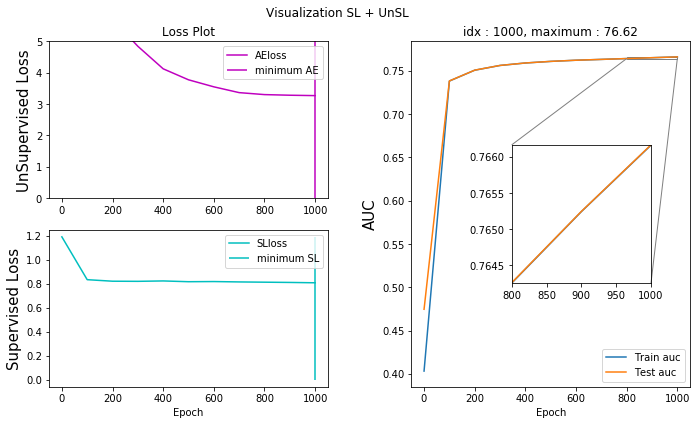

In [66]:
vis(store, "./usl_sl_combine_train.png")

In [ ]:
def vis(epoch, loss, path) :
    clear_output()
    plt.plot(epoch , loss )
    select= np.argmin(loss)
    msg = f"Epoch : {epoch[-1]}, Loss : {loss[-1]:.3f}, minimum : {loss[select]:.3f}"
    plt.title(msg)
    plt.savefig(path)
    plt.show()

In [ ]:
## version1
def vis(store:dict, path:str) :
    clear_output()
    fig, axes = plt.subplots(1,2,figsize=(10,6))
    ax = axes.flatten()
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.99, 
            top=0.9, wspace=0.3, hspace=0.2)
    ax[0].plot(store["epoch"],store["aeloss"],label = "AEloss", color='m')
    ax[0].plot(store["epoch"],store["slloss"],label = "SLloss", color='c')
    ax[0].set_ylabel('Loss', fontsize= 15)
    ax[0].set_xlabel('Epoch')
    select_ae= np.argmin(store["aeloss"])
    select_sl= np.argmin(store["slloss"])
    ax[0].set_ylim(0,3)
    ax[0].vlines(store["epoch"][select_ae],0,5, label='minimum AE', color='m')
    ax[0].vlines(store["epoch"][select_sl],0,5, label='minimum SL', color='c')
    ax[0].set_title("Loss Plot")
    ax[0].legend()
    ax[1].plot(store["epoch"],store["auc"],label = "Train auc")
    ax[1].plot(store["epoch"],store["teauc"],label = "Test auc")
    ax[1].set_ylabel('AUC', fontsize= 15)
    ax[1].set_xlabel('Epoch')
    select= np.argmax(store["auc"])
    msg = f"idx : {store['epoch'][select]}, maximum : {store['auc'][select]*100:.2f}"
    ax[1].set_title(msg)             
    ax[1].legend()
#     msg = f"Epoch : {epoch[-1]}, Loss : {loss[-1]:.3f}, Auc : {aucs[-1]:.3f}"
    plt.suptitle("Visualization SL + UnSL")
    plt.savefig(path)
    plt.show()
## version2
def vis(store:dict, path:str) :
    clear_output()
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(nrows=2, ncols=2)
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[:, 1])
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.99, 
            top=0.9, wspace=0.3, hspace=0.2)
    ax0.plot(store["epoch"],store["aeloss"],label = "AEloss", color='m')
    ax0.set_ylabel('UnSupervised Loss', fontsize= 15)
    ax0.set_ylim(0,5)
    select_ae= np.argmin(store["aeloss"])
    ax0.vlines(store["epoch"][select_ae],0,5, label='minimum AE', color='m')
    ax0.set_title("Loss Plot")
    ax0.legend()
    ax1.plot(store["epoch"],store["slloss"],label = "SLloss", color='c')
    ax1.set_xlabel('Epoch')
    select_sl= np.argmin(store["slloss"])
    ax1.vlines(store["epoch"][select_sl],0,np.max(store["slloss"]),
               label='minimum SL', color='c')
    ax1.set_ylabel('Supervised Loss', fontsize= 15)
    ax1.legend()
    ax2.plot(store["epoch"],store["auc"],label = "Train auc")
    ax2.plot(store["epoch"],store["teauc"],label = "Test auc")
    ax2.set_ylabel('AUC', fontsize= 15)
    ax2.set_xlabel('Epoch')
    select= np.argmax(store["auc"])
    msg = f"idx : {store['epoch'][select]}, maximum : {store['auc'][select]*100:.2f}"
    ax2.set_title(msg)             
#     ax2.set_ylim(0.7,store['auc'][select]+0.1)
    ax2.legend()
#     msg = f"Epoch : {epoch[-1]}, Loss : {loss[-1]:.3f}, Auc : {aucs[-1]:.3f}"
    plt.suptitle("Visualization SL + UnSL")
    plt.savefig(path)
    plt.show()